 # Learning about network behavior with Mahi-Mahi
 
 ## Summary
 
[mahimahi](http://mahimahi.mit.edu/) is a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.
 
This jupyter notebook uses mahimahi to demonstrate how network traffic operates under different conditions.
 
The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
 ## Installation
 
 I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install jupyter

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10)
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```
 
 ## TODO

I will be adding implementations of different congestion control algorithms here and comparing how each of them
does under different networking conditions.


In [9]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from subprocess import Popen
from typing import Dict
from typing import List
from threading import Thread

In [10]:
RECEIVER_FILE = "run_receiver.py"

In [11]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

In [12]:
# Helper methods

def generate_mahimahi_command(mahimahi_settings: Dict):
    if mahimahi_settings.get('loss'):
        loss_directive = "mm-loss downlink %f" % mahimahi_settings.get('loss')
    else:
        loss_directive = ""
    return "mm-delay {delay} {loss_directive} mm-link traces/{trace_file} traces/{trace_file} --downlink-queue=droptail --downlink-queue-args=packets={queue_size}".format(
      delay=mahimahi_settings['delay'],
      queue_size=mahimahi_settings['queue_size'],
      loss_directive=loss_directive,
      trace_file=mahimahi_settings['trace_file']
    )
        
def get_open_udp_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

        
def print_performance(sender, num_seconds: int):
    print("Results for sender %d:" % sender.port)
    print("Total Acks: %d" % sender.strategy.total_acks)
    print("Num Duplicate Acks: %d" % sender.strategy.num_duplicate_acks)
    print("Total # of successful acks: %d" % sender.strategy.ack_count)
    
    print("Throughput in acks: %d" % (sender.strategy.ack_count/num_seconds))
    print("Throughput in ack-bytes: %d" % (1500 * (sender.strategy.ack_count/num_seconds)))
    print("%% duplicate acks: %f" % ((float(sender.strategy.num_duplicate_acks * 100))/sender.strategy.total_acks))
    print("Total bytes sent: %d" % sender.strategy.sent_bytes)
    print("Throughput (bytes/s): %f" % (sender.strategy.sent_bytes/num_seconds))
    print("Average RTT (ms): %f" % ((float(sum(sender.strategy.rtts))/len(sender.strategy.rtts)) * 1000))
    
    timestamps = [ ack[0] for ack in sender.strategy.times_of_acknowledgements]
    seq_nums = [ ack[1] for ack in sender.strategy.times_of_acknowledgements]

    plt.scatter(timestamps, seq_nums)
    plt.xlabel("Timestamps")
    plt.ylabel("Sequence Numbers")

    plt.show()
    
    plt.plot(sender.strategy.cwnds)
    plt.xlabel("Time")
    plt.ylabel("Congestion Window Size")
    plt.show()
    print("")
    
    plt.plot(sender.strategy.slow_start_thresholds)
    plt.xlabel("Time")
    plt.ylabel("Slow start threhold")
    plt.show()
    print("")
    
def run_with_mahi_settings(mahimahi_settings: Dict, seconds_to_run: int, senders: List):
    mahimahi_cmd = generate_mahimahi_command(mahimahi_settings)

    sender_ports = " ".join(["$MAHIMAHI_BASE %s" % sender.port for sender in senders])
    
    cmd = "%s -- sh -c 'python3 %s %s'" % (mahimahi_cmd, RECEIVER_FILE, sender_ports)
    receiver_process = Popen(cmd, shell=True)
    for sender in senders:
        sender.handshake()
    threads = [Thread(target=sender.run, args=[seconds_to_run]) for sender in senders]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    
    for sender in senders:
        print_performance(sender, seconds_to_run)
    receiver_process.kill()


In [13]:
READ_FLAGS = select.POLLIN | select.POLLPRI
WRITE_FLAGS = select.POLLOUT
ERR_FLAGS = select.POLLERR | select.POLLHUP | select.POLLNVAL
READ_ERR_FLAGS = READ_FLAGS | ERR_FLAGS
ALL_FLAGS = READ_FLAGS | WRITE_FLAGS | ERR_FLAGS

In [14]:
from src.senders import Sender

In [32]:
class SenderStrategy(object):
    def next_packet_to_send(self):
        raise NotImplementedError
        
    def process_ack(self, ack: str):
        raise NotImplememntedError

class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, intial_cwnd: int) -> None:
        

class TahoeSender(Sender):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
        self.initial_cwnd = initial_cwnd
        self.cwnd = initial_cwnd
        self.slow_start_thresh = slow_start_thresh
        self.fast_retransmit_packet = None

        super().__init__(port)
        
    def window_is_open(self) -> bool:
        # Returns true if the congestion window is not full
        return len(self.unacknowledged_packets) < self.cwnd

    def send(self):
        if self.fast_retransmit_packet:
            data = self.fast_retransmit_packet
            serialized_data = json.dumps(data)
            self.fast_retransmit_packet = None
        elif self.window_is_open():
            data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'sent_bytes': self.sent_bytes
            }
            
            self.unacknowledged_packets[self.seq_num] = data
            self.seq_num += 1
    
        serialized_data = json.dumps(data)
        self.sock.sendto(serialized_data.encode(), self.peer_addr)
        time.sleep(0)
    
    def recv(self):
        serialized_ack, addr = self.sock.recvfrom(1600)

        ack = json.loads(serialized_ack.decode())
        if ack.get('handshake'):
            return
        
        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            self.curr_duplicate_acks += 1
            
            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                
                # Go into fast retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = self.cwnd/2
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            self.curr_duplicate_acks = 0
            
            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1 
            elif ack['seq_num'] % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1
    
        self.cwnds.append(self.cwnd) 

In [33]:
class RenoSender(Sender):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
        self.initial_cwnd = initial_cwnd
        self.cwnd = initial_cwnd
        self.slow_start_thresh = slow_start_thresh

        super().__init__(port)
        
    def window_is_open(self):
        # Returns true if the congestion window is not full
        return self.seq_num - self.next_ack < self.cwnd

    def send(self):
        serialized_data = json.dumps({
            'seq_num': self.seq_num,
            'send_ts': time.time(),
            'sent_bytes': self.sent_bytes
        })
        self.unacknowledged_packets[self.seq_num] = True
        self.seq_num += 1
        self.sock.sendto(serialized_data.encode(), self.peer_addr)
        time.sleep(0)
    
    def recv(self):
        serialized_ack, addr = self.sock.recvfrom(1600)

        ack = json.loads(serialized_ack.decode())
        if ack.get('handshake'):
            return
        
        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            self.curr_duplicate_acks += 1
            
            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit

                self.seq_num = ack['seq_num'] + 1
                self.slow_start_thresh = self.cwnd/2
                self.cwnd = self.slow_start_thresh
        else:
            self.curr_duplicate_acks = 0
            del self.unacknowledged_packets[ack['seq_num']]
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1 
            elif ack['seq_num'] % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1
    
        self.cwnds.append(self.cwnd) 

# Solo Testing

[sender] Connected to receiver: 100.64.0.2:36532

Results for sender 35829:
Total Acks: 3995
Num Duplicate Acks: 345
% duplicate acks: 8.635795
Total bytes sent: 251665
Throughput (bytes/s): 2097.208333
Average RTT (ms): 213.751742


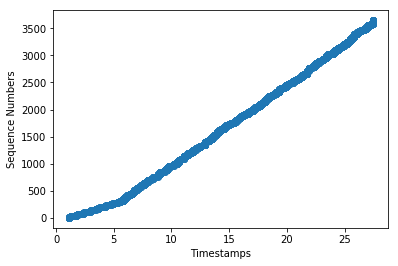

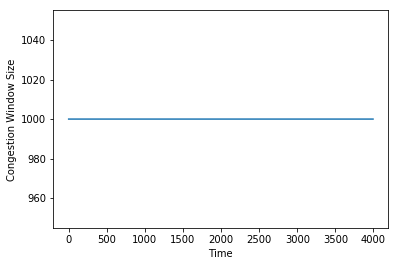

In [11]:
# Test of multiple senders


mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port)])

[sender] Connected to receiver: 100.64.0.4:53287

Results for sender 50764:
Total Acks: 25874
Num Duplicate Acks: 30
% duplicate acks: 0.115947
Total bytes sent: 1826747
Throughput (bytes/s): 15222.891667
Average RTT (ms): 198.400031


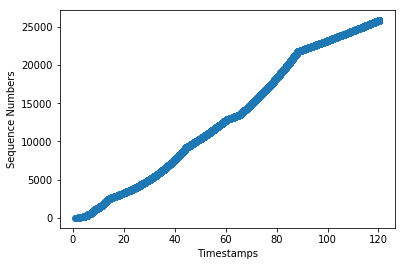

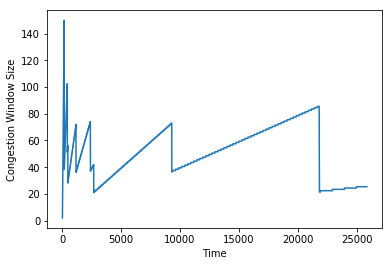

In [12]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port)])


# Testing Contention

[sender] Connected to receiver: 100.64.0.2:47120

[sender] Connected to receiver: 100.64.0.2:47120

Results for sender 57736:
Total Acks: 385
Num Duplicate Acks: 51
% duplicate acks: 13.246753
Total bytes sent: 22278
Throughput (bytes/s): 185.650000
Average RTT (ms): 261.672038


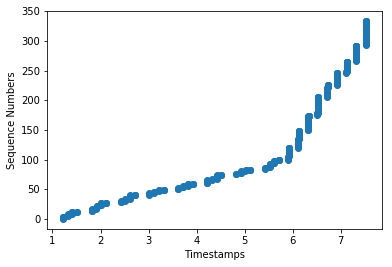

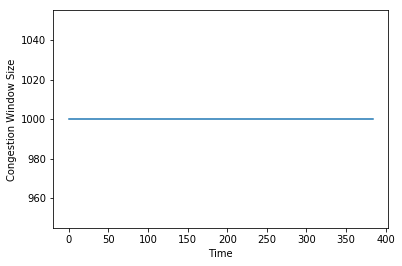


Results for sender 35824:
Total Acks: 924
Num Duplicate Acks: 96
% duplicate acks: 10.389610
Total bytes sent: 55730
Throughput (bytes/s): 464.416667
Average RTT (ms): 247.990191


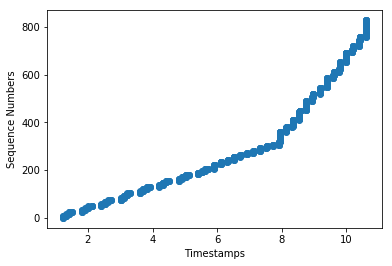

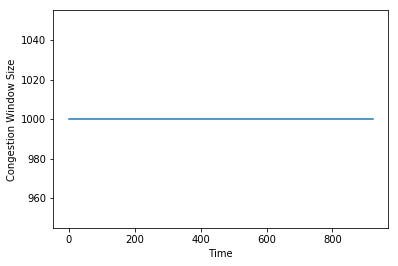

In [15]:
# 2 Fixed Windows

mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port), FixedWindowSender(1000, port2)])


[sender] Connected to receiver: 100.64.0.4:42762

[sender] Connected to receiver: 100.64.0.4:42762

Results for sender 57649:
Total Acks: 26097
Num Duplicate Acks: 30
% duplicate acks: 0.114956
Total bytes sent: 1842756
Throughput (bytes/s): 15356.300000
Average RTT (ms): 195.573789


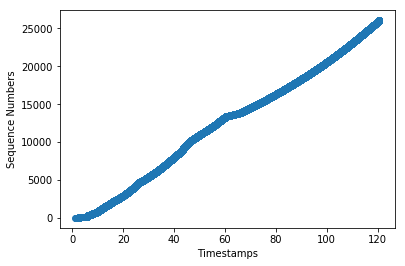

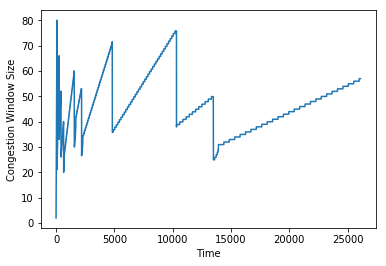


Results for sender 58071:
Total Acks: 3989
Num Duplicate Acks: 29
% duplicate acks: 0.726999
Total bytes sent: 273277
Throughput (bytes/s): 2277.308333
Average RTT (ms): 205.315373


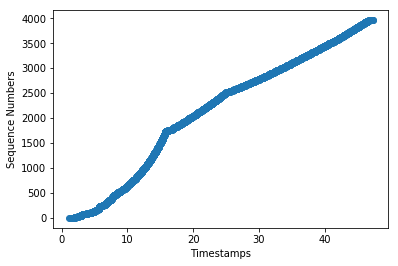

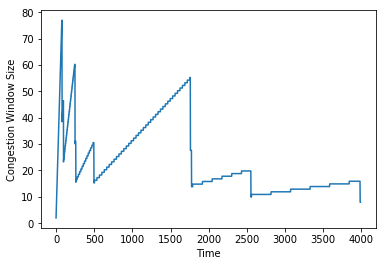

In [16]:
# Two Renos
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port), RenoSender(50, 1, port2)])


[sender] Connected to receiver: 100.64.0.2:41593

[sender] Connected to receiver: 100.64.0.2:41593

Results for sender 37244:
Total Acks: 592
Num Duplicate Acks: 45
% duplicate acks: 7.601351
Total bytes sent: 36660
Throughput (bytes/s): 305.500000
Average RTT (ms): 294.854688


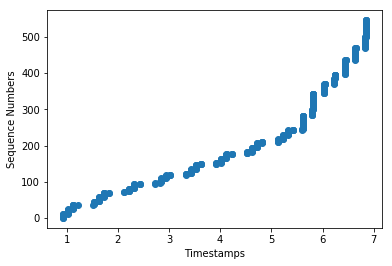

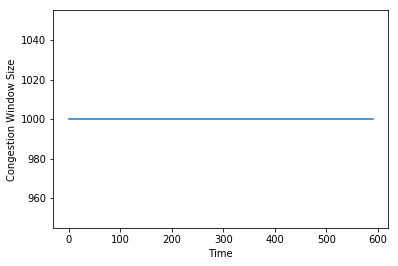


Results for sender 51258:
Total Acks: 86
Num Duplicate Acks: 9
% duplicate acks: 10.465116
Total bytes sent: 5019
Throughput (bytes/s): 41.825000
Average RTT (ms): 340.986899


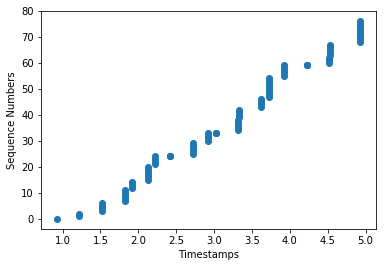

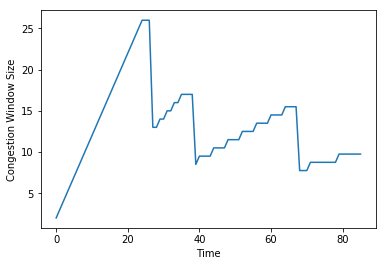

In [17]:
# Reno & Fixed Window
mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port), RenoSender(50, 1, port2)])

[sender] Connected to receiver: 100.64.0.4:51033

Results for sender 33149:
Total Acks: 550914
Num Duplicate Acks: 27
% duplicate acks: 0.004901
Total bytes sent: 40352738
Throughput (bytes/s): 336272.816667
Average RTT (ms): 59.752861


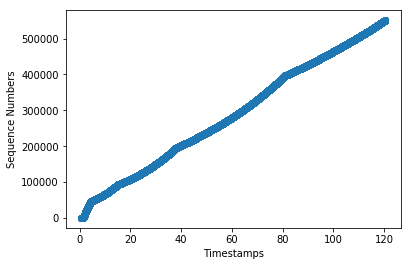

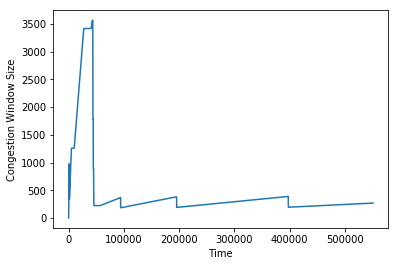

In [18]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [RenoSender(50, 1, port)])


In [6]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()

run_with_mahi_settings(mahimahi_settings, 120, [FixedWindowSender(1000, port)])


NameError: name 'FixedWindowSender' is not defined

In [5]:
from src.senders import Sender
from src.strategies import TahoeStrategy, FixedWindowStrategy

[sender] Connected to receiver: 100.64.0.30:52149

Results for sender 48311:
Total Acks: 13679
Num Duplicate Acks: 13067
% duplicate acks: 95.525989
Total bytes sent: 41055
Throughput (bytes/s): 4105.500000
Average RTT (ms): 352.637965


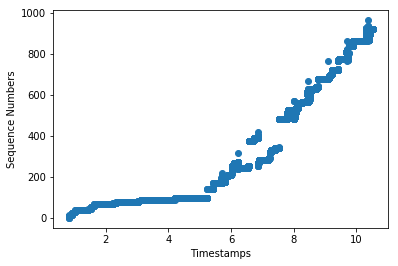

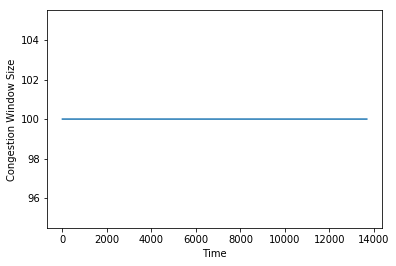

In [7]:
# Run this in the demo

mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()
strat = FixedWindowStrategy(100)
run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, strat)])

In [5]:
from src.strategies import SenderStrategy
import json
import time
from typing import List, Dict, Optional


In [23]:
BETA_CUBIC = 0.7

class CubicStrategy(SenderStrategy):
    def __init__(self, c: float) -> None:
        self.c = c
        self.cwnd = 2
        self.slow_start_thresh = 42

        # List of tuples of ack_time and seq_num

        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False

        self.duplicated_ack = None
        
        self.w_max = self.slow_start_thresh
        self.congestion_avoidance_began_at = None
        self.ack_count = 0
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # Returns true if the congestion window is not full

        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        if self.retransmitting_packet and time.time() - self.time_of_retransmit > 1:
            print("Doing another retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            
            print("Doing a retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'sent_bytes': self.sent_bytes
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def compute_w_est(self) -> int:
        average_rtt = sum(self.rtts)/len(self.rtts)
        
        return (
            self.w_max * BETA_CUBIC + (
              ((3*(1 - BETA_CUBIC)) * (
                  (time.time() - self.congestion_avoidance_began_at)/average_rtt) ) /(1 + BETA_CUBIC)
            )
        )
    
    def compute_w_cubic(self, t: float) -> int:

        k = (self.w_max * ((1 - BETA_CUBIC)/self.c)) ** (1/3)
        print("k: %d, t: %f, w_max: %d" % (k, t, self.w_max))
        return self.c * (((t)-k) ** 3) + self.w_max
    
    def average_rtt(self):
        return sum(self.rtts)/len(self.rtts)
    
    def process_ack(self, serialized_ack: str) -> None:

        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                print("HIT A DROP OF PACKET %d" % (ack['seq_num'] + 1))
                self.w_max = self.cwnd
                self.slow_start_thresh = max(2, self.cwnd * BETA_CUBIC)
                self.cwnd = self.cwnd * BETA_CUBIC
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                # Acknowledge all packets where seq_num < ack['seq_num']
                # Throw out all unacknowledged packets and start over

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            self.ack_count += 1
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.congestion_avoidance_began_at is None and self.cwnd >= self.slow_start_thresh:
                self.congestion_avoidance_began_at = time.time()
            
            if self.cwnd < self.slow_start_thresh:
                self.congestion_avoidance_began_at = None
                # In slow start
                self.cwnd += 1

            else:
                # In congestion avoidance
                w_est = self.compute_w_est()
                t = (time.time() - self.congestion_avoidance_began_at)
                w_cubic = self.compute_w_cubic(t)
                
                if w_cubic > w_est:
                    a = (self.compute_w_cubic(t + self.average_rtt()) - self.cwnd)/self.cwnd 
                    print("a: %f" % a)
                    self.cwnd += a
                else:
                    self.cwnd = w_est


        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)


[sender] Connected to receiver: 100.64.0.20:57648

k: 4, t: 0.000015, w_max: 100
k: 4, t: 0.180065, w_max: 100
a: -0.263189
k: 4, t: 0.000007, w_max: 100
k: 4, t: 0.180101, w_max: 100
a: -0.268571
k: 4, t: 0.000372, w_max: 100
k: 4, t: 0.180492, w_max: 100
a: -0.266540
k: 4, t: 0.000977, w_max: 100
k: 4, t: 0.181126, w_max: 100
a: -0.264465
k: 4, t: 0.000005, w_max: 100
k: 4, t: 0.180225, w_max: 100
a: -0.270000
k: 4, t: 0.000622, w_max: 100
k: 4, t: 0.180882, w_max: 100
a: -0.267914
k: 4, t: 0.001503, w_max: 100
k: 4, t: 0.181811, w_max: 100
a: -0.265780
k: 4, t: 0.002712, w_max: 100
k: 4, t: 0.183077, w_max: 100
a: -0.263584
k: 4, t: 0.000005, w_max: 100
k: 4, t: 0.180489, w_max: 100
a: -0.269462
k: 4, t: 0.000520, w_max: 100
k: 4, t: 0.181066, w_max: 100
a: -0.267393
k: 4, t: 0.006012, w_max: 100
k: 4, t: 0.186668, w_max: 100
a: -0.264350
k: 4, t: 0.007604, w_max: 100
k: 4, t: 0.188382, w_max: 100
a: -0.262073
k: 4, t: 0.000011, w_max: 100
k: 4, t: 0.181062, w_max: 100
a: -0.268892


k: 4, t: 0.000009, w_max: 100
k: 4, t: 0.192779, w_max: 100
a: -0.266357
k: 4, t: 0.000200, w_max: 100
k: 4, t: 0.192925, w_max: 100
a: -0.264385
k: 4, t: 0.001600, w_max: 100
k: 4, t: 0.194282, w_max: 100
a: -0.262182
k: 4, t: 0.000010, w_max: 100
k: 4, t: 0.192612, w_max: 100
a: -0.267894
k: 4, t: 0.002036, w_max: 100
k: 4, t: 0.194606, w_max: 100
a: -0.265562
k: 4, t: 0.003369, w_max: 100
k: 4, t: 0.195903, w_max: 100
a: -0.263369
k: 4, t: 0.004567, w_max: 100
k: 4, t: 0.197066, w_max: 100
a: -0.261208
k: 4, t: 0.000010, w_max: 100
k: 4, t: 0.192462, w_max: 100
a: -0.267502
k: 4, t: 0.000269, w_max: 100
k: 4, t: 0.192690, w_max: 100
a: -0.265511
k: 4, t: 0.004633, w_max: 100
k: 4, t: 0.197035, w_max: 100
a: -0.262728
k: 4, t: 0.005096, w_max: 100
k: 4, t: 0.197476, w_max: 100
a: -0.260708
k: 4, t: 0.000010, w_max: 100
k: 4, t: 0.192338, w_max: 100
a: -0.267116
k: 4, t: 0.004004, w_max: 100
k: 4, t: 0.196312, w_max: 100
a: -0.264403
k: 4, t: 0.004433, w_max: 100
k: 4, t: 0.196706, w_

k: 4, t: 0.000010, w_max: 100
k: 4, t: 0.187183, w_max: 100
a: -0.267752
k: 4, t: 0.000169, w_max: 100
k: 4, t: 0.187325, w_max: 100
a: -0.265775
k: 4, t: 0.001279, w_max: 100
k: 4, t: 0.188419, w_max: 100
a: -0.263616
k: 4, t: 0.075928, w_max: 100
k: 4, t: 0.263054, w_max: 100
a: -0.247409
k: 4, t: 0.000007, w_max: 100
k: 4, t: 0.187104, w_max: 100
a: -0.267444
k: 4, t: 0.000146, w_max: 100
k: 4, t: 0.187229, w_max: 100
a: -0.265470
k: 4, t: 0.000947, w_max: 100
k: 4, t: 0.188016, w_max: 100
a: -0.263372
k: 4, t: 0.000012, w_max: 100
k: 4, t: 0.187058, w_max: 100
a: -0.268931
k: 4, t: 0.000763, w_max: 100
k: 4, t: 0.187797, w_max: 100
a: -0.266835
k: 4, t: 0.000916, w_max: 100
k: 4, t: 0.187938, w_max: 100
a: -0.264860
k: 4, t: 0.001578, w_max: 100
k: 4, t: 0.188589, w_max: 100
a: -0.262790
k: 4, t: 0.000009, w_max: 100
k: 4, t: 0.186999, w_max: 100
a: -0.268483
k: 4, t: 0.000272, w_max: 100
k: 4, t: 0.187251, w_max: 100
a: -0.266482
k: 4, t: 0.000496, w_max: 100
k: 4, t: 0.187464, w_

k: 4, t: 0.002036, w_max: 100
k: 4, t: 0.187019, w_max: 100
a: -0.263162
k: 4, t: 0.000013, w_max: 100
k: 4, t: 0.184986, w_max: 100
a: -0.268935
k: 4, t: 0.000162, w_max: 100
k: 4, t: 0.185129, w_max: 100
a: -0.266954
k: 4, t: 0.000271, w_max: 100
k: 4, t: 0.185232, w_max: 100
a: -0.264984
k: 4, t: 0.000376, w_max: 100
k: 4, t: 0.185332, w_max: 100
a: -0.263019
k: 4, t: 0.000019, w_max: 100
k: 4, t: 0.184963, w_max: 100
a: -0.268476
k: 4, t: 0.000344, w_max: 100
k: 4, t: 0.185283, w_max: 100
a: -0.266462
k: 4, t: 0.002448, w_max: 100
k: 4, t: 0.187378, w_max: 100
a: -0.264106
k: 4, t: 0.004658, w_max: 100
k: 4, t: 0.189581, w_max: 100
a: -0.261735
k: 4, t: 0.000012, w_max: 100
k: 4, t: 0.184922, w_max: 100
a: -0.268043
k: 4, t: 0.000701, w_max: 100
k: 4, t: 0.185606, w_max: 100
a: -0.265959
k: 4, t: 0.003045, w_max: 100
k: 4, t: 0.187947, w_max: 100
a: -0.263556
k: 4, t: 0.000013, w_max: 100
k: 4, t: 0.184906, w_max: 100
a: -0.269513
k: 4, t: 0.000527, w_max: 100
k: 4, t: 0.185417, w_

k: 4, t: 0.000024, w_max: 100
k: 4, t: 0.183751, w_max: 100
a: -0.268468
k: 4, t: 0.000578, w_max: 100
k: 4, t: 0.184300, w_max: 100
a: -0.266408
k: 4, t: 0.000765, w_max: 100
k: 4, t: 0.184483, w_max: 100
a: -0.264424
k: 4, t: 0.001579, w_max: 100
k: 4, t: 0.185291, w_max: 100
a: -0.262321
k: 4, t: 0.000020, w_max: 100
k: 4, t: 0.183724, w_max: 100
a: -0.268026
k: 4, t: 0.001505, w_max: 100
k: 4, t: 0.185205, w_max: 100
a: -0.265786
k: 4, t: 0.001771, w_max: 100
k: 4, t: 0.185466, w_max: 100
a: -0.263788
k: 4, t: 0.000022, w_max: 100
k: 4, t: 0.183713, w_max: 100
a: -0.269495
k: 4, t: 0.000372, w_max: 100
k: 4, t: 0.184062, w_max: 100
a: -0.267472
k: 4, t: 0.000692, w_max: 100
k: 4, t: 0.184379, w_max: 100
a: -0.265460
k: 4, t: 0.000938, w_max: 100
k: 4, t: 0.184622, w_max: 100
a: -0.263466
k: 4, t: 0.000019, w_max: 100
k: 4, t: 0.183692, w_max: 100
a: -0.269022
k: 4, t: 0.000291, w_max: 100
k: 4, t: 0.183960, w_max: 100
a: -0.267016
k: 4, t: 0.001012, w_max: 100
k: 4, t: 0.184676, w_

k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.183342, w_max: 100
a: -0.268426
k: 4, t: 0.002434, w_max: 100
k: 4, t: 0.185747, w_max: 100
a: -0.266005
k: 4, t: 0.003035, w_max: 100
k: 4, t: 0.186345, w_max: 100
a: -0.263942
k: 4, t: 0.003238, w_max: 100
k: 4, t: 0.186543, w_max: 100
a: -0.261961
k: 4, t: 0.000019, w_max: 100
k: 4, t: 0.183318, w_max: 100
a: -0.267992
k: 4, t: 0.000235, w_max: 100
k: 4, t: 0.183531, w_max: 100
a: -0.265998
k: 4, t: 0.000398, w_max: 100
k: 4, t: 0.183691, w_max: 100
a: -0.264019
k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.183311, w_max: 100
a: -0.269458
k: 4, t: 0.001837, w_max: 100
k: 4, t: 0.185119, w_max: 100
a: -0.267152
k: 4, t: 0.002993, w_max: 100
k: 4, t: 0.186271, w_max: 100
a: -0.264979
k: 4, t: 0.004070, w_max: 100
k: 4, t: 0.187346, w_max: 100
a: -0.262825
k: 4, t: 0.000019, w_max: 100
k: 4, t: 0.183289, w_max: 100
a: -0.268996
k: 4, t: 0.000220, w_max: 100
k: 4, t: 0.183486, w_max: 100
a: -0.267003
k: 4, t: 0.001246, w_max: 100
k: 4, t: 0.184510, w_

k: 4, t: 0.001339, w_max: 100
k: 4, t: 0.184207, w_max: 100
a: -0.262867
k: 4, t: 0.000016, w_max: 100
k: 4, t: 0.182883, w_max: 100
a: -0.268514
k: 4, t: 0.004222, w_max: 100
k: 4, t: 0.187089, w_max: 100
a: -0.265744
k: 4, t: 0.006860, w_max: 100
k: 4, t: 0.189725, w_max: 100
a: -0.263286
k: 4, t: 0.008655, w_max: 100
k: 4, t: 0.191518, w_max: 100
a: -0.260997
k: 4, t: 0.000017, w_max: 100
k: 4, t: 0.182877, w_max: 100
a: -0.268090
k: 4, t: 0.000233, w_max: 100
k: 4, t: 0.183092, w_max: 100
a: -0.266095
k: 4, t: 0.000397, w_max: 100
k: 4, t: 0.183253, w_max: 100
a: -0.264115
k: 4, t: 0.000022, w_max: 100
k: 4, t: 0.182874, w_max: 100
a: -0.269553
k: 4, t: 0.001642, w_max: 100
k: 4, t: 0.184493, w_max: 100
a: -0.267283
k: 4, t: 0.001882, w_max: 100
k: 4, t: 0.184732, w_max: 100
a: -0.265286
k: 4, t: 0.008480, w_max: 100
k: 4, t: 0.191328, w_max: 100
a: -0.262057
k: 4, t: 0.000025, w_max: 100
k: 4, t: 0.182868, w_max: 100
a: -0.269089
k: 4, t: 0.003268, w_max: 100
k: 4, t: 0.186109, w_

k: 4, t: 0.000023, w_max: 100
k: 4, t: 0.182664, w_max: 100
a: -0.268486
k: 4, t: 0.000263, w_max: 100
k: 4, t: 0.182903, w_max: 100
a: -0.266486
k: 4, t: 0.000431, w_max: 100
k: 4, t: 0.183071, w_max: 100
a: -0.264503
k: 4, t: 0.000032, w_max: 100
k: 4, t: 0.182669, w_max: 100
a: -0.269937
k: 4, t: 0.000570, w_max: 100
k: 4, t: 0.183205, w_max: 100
a: -0.267877
k: 4, t: 0.007554, w_max: 100
k: 4, t: 0.190190, w_max: 100
a: -0.264569
k: 4, t: 0.011803, w_max: 100
k: 4, t: 0.194442, w_max: 100
a: -0.261802
k: 4, t: 0.000032, w_max: 100
k: 4, t: 0.182678, w_max: 100
a: -0.269471
k: 4, t: 0.000277, w_max: 100
k: 4, t: 0.182927, w_max: 100
a: -0.267467
k: 4, t: 0.000443, w_max: 100
k: 4, t: 0.183096, w_max: 100
a: -0.265483
k: 4, t: 0.000620, w_max: 100
k: 4, t: 0.183276, w_max: 100
a: -0.263500
k: 4, t: 0.000017, w_max: 100
k: 4, t: 0.182676, w_max: 100
a: -0.268994
k: 4, t: 0.000193, w_max: 100
k: 4, t: 0.182852, w_max: 100
a: -0.267005
k: 4, t: 0.000417, w_max: 100
k: 4, t: 0.183075, w_

k: 4, t: 0.005939, w_max: 100
k: 4, t: 0.188681, w_max: 100
a: -0.265658
k: 4, t: 0.006428, w_max: 100
k: 4, t: 0.189171, w_max: 100
a: -0.263618
k: 4, t: 0.006601, w_max: 100
k: 4, t: 0.189346, w_max: 100
a: -0.261644
k: 4, t: 0.000023, w_max: 100
k: 4, t: 0.182765, w_max: 100
a: -0.268327
k: 4, t: 0.000804, w_max: 100
k: 4, t: 0.183545, w_max: 100
a: -0.266222
k: 4, t: 0.002329, w_max: 100
k: 4, t: 0.185069, w_max: 100
a: -0.263976
k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.182763, w_max: 100
a: -0.269787
k: 4, t: 0.000332, w_max: 100
k: 4, t: 0.183066, w_max: 100
a: -0.267772
k: 4, t: 0.000558, w_max: 100
k: 4, t: 0.183291, w_max: 100
a: -0.265776
k: 4, t: 0.005536, w_max: 100
k: 4, t: 0.188267, w_max: 100
a: -0.262859
k: 4, t: 0.000020, w_max: 100
k: 4, t: 0.182749, w_max: 100
a: -0.269311
k: 4, t: 0.003445, w_max: 100
k: 4, t: 0.186174, w_max: 100
a: -0.266691
k: 4, t: 0.004530, w_max: 100
k: 4, t: 0.187259, w_max: 100
a: -0.264532
k: 4, t: 0.005381, w_max: 100
k: 4, t: 0.188110, w_

k: 4, t: 0.184921, w_max: 100
a: -0.265243
k: 4, t: 0.003342, w_max: 100
k: 4, t: 0.186018, w_max: 100
a: -0.263083
k: 4, t: 0.000025, w_max: 100
k: 4, t: 0.182700, w_max: 100
a: -0.269108
k: 4, t: 0.000957, w_max: 100
k: 4, t: 0.183632, w_max: 100
a: -0.266972
k: 4, t: 0.001158, w_max: 100
k: 4, t: 0.183832, w_max: 100
a: -0.264983
k: 4, t: 0.001316, w_max: 100
k: 4, t: 0.183989, w_max: 100
a: -0.263006
k: 4, t: 0.000020, w_max: 100
k: 4, t: 0.182692, w_max: 100
a: -0.268645
k: 4, t: 0.001130, w_max: 100
k: 4, t: 0.183801, w_max: 100
a: -0.266476
k: 4, t: 0.002046, w_max: 100
k: 4, t: 0.184717, w_max: 100
a: -0.264348
k: 4, t: 0.005044, w_max: 100
k: 4, t: 0.187714, w_max: 100
a: -0.261820
k: 4, t: 0.000022, w_max: 100
k: 4, t: 0.182690, w_max: 100
a: -0.268201
k: 4, t: 0.001073, w_max: 100
k: 4, t: 0.183742, w_max: 100
a: -0.266043
k: 4, t: 0.001958, w_max: 100
k: 4, t: 0.184625, w_max: 100
a: -0.263923
k: 4, t: 0.000018, w_max: 100
k: 4, t: 0.182683, w_max: 100
a: -0.269665
k: 4, t:

k: 4, t: 0.000025, w_max: 100
k: 4, t: 0.182510, w_max: 100
a: -0.268509
k: 4, t: 0.001151, w_max: 100
k: 4, t: 0.183635, w_max: 100
a: -0.266336
k: 4, t: 0.001405, w_max: 100
k: 4, t: 0.183888, w_max: 100
a: -0.264338
k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.182507, w_max: 100
a: -0.269964
k: 4, t: 0.000358, w_max: 100
k: 4, t: 0.182838, w_max: 100
a: -0.267943
k: 4, t: 0.000644, w_max: 100
k: 4, t: 0.183121, w_max: 100
a: -0.265935
k: 4, t: 0.003891, w_max: 100
k: 4, t: 0.186367, w_max: 100
a: -0.263355
k: 4, t: 0.000022, w_max: 100
k: 4, t: 0.182496, w_max: 100
a: -0.269480
k: 4, t: 0.000302, w_max: 100
k: 4, t: 0.182774, w_max: 100
a: -0.267470
k: 4, t: 0.000584, w_max: 100
k: 4, t: 0.183056, w_max: 100
a: -0.265464
k: 4, t: 0.002604, w_max: 100
k: 4, t: 0.185075, w_max: 100
a: -0.263123
k: 4, t: 0.000104, w_max: 100
k: 4, t: 0.182572, w_max: 100
a: -0.268991
k: 4, t: 0.002106, w_max: 100
k: 4, t: 0.184573, w_max: 100
a: -0.266647
k: 4, t: 0.002517, w_max: 100
k: 4, t: 0.184984, w_

k: 4, t: 0.002906, w_max: 100
k: 4, t: 0.185254, w_max: 100
a: -0.264845
k: 4, t: 0.006707, w_max: 100
k: 4, t: 0.189054, w_max: 100
a: -0.262161
k: 4, t: 0.000030, w_max: 100
k: 4, t: 0.182375, w_max: 100
a: -0.268851
k: 4, t: 0.002672, w_max: 100
k: 4, t: 0.185016, w_max: 100
a: -0.266384
k: 4, t: 0.003154, w_max: 100
k: 4, t: 0.185498, w_max: 100
a: -0.264342
k: 4, t: 0.006474, w_max: 100
k: 4, t: 0.188818, w_max: 100
a: -0.261751
k: 4, t: 0.000034, w_max: 100
k: 4, t: 0.182379, w_max: 100
a: -0.268406
k: 4, t: 0.000578, w_max: 100
k: 4, t: 0.182922, w_max: 100
a: -0.266346
k: 4, t: 0.001991, w_max: 100
k: 4, t: 0.184336, w_max: 100
a: -0.264122
k: 4, t: 0.000031, w_max: 100
k: 4, t: 0.182374, w_max: 100
a: -0.269864
k: 4, t: 0.001729, w_max: 100
k: 4, t: 0.184071, w_max: 100
a: -0.267578
k: 4, t: 0.002664, w_max: 100
k: 4, t: 0.185005, w_max: 100
a: -0.265445
k: 4, t: 0.008968, w_max: 100
k: 4, t: 0.191309, w_max: 100
a: -0.262273
k: 4, t: 0.000029, w_max: 100
k: 4, t: 0.182368, w_

k: 4, t: 0.000440, w_max: 100
k: 4, t: 0.182949, w_max: 100
a: -0.268053
k: 4, t: 0.004883, w_max: 100
k: 4, t: 0.187396, w_max: 100
a: -0.265237
k: 4, t: 0.006281, w_max: 100
k: 4, t: 0.188800, w_max: 100
a: -0.263019
k: 4, t: 0.000020, w_max: 100
k: 4, t: 0.182548, w_max: 100
a: -0.269608
k: 4, t: 0.000158, w_max: 100
k: 4, t: 0.182690, w_max: 100
a: -0.267624
k: 4, t: 0.000289, w_max: 100
k: 4, t: 0.182826, w_max: 100
a: -0.265646
k: 4, t: 0.000530, w_max: 100
k: 4, t: 0.183071, w_max: 100
a: -0.263650
k: 4, t: 0.000053, w_max: 100
k: 4, t: 0.182600, w_max: 100
a: -0.269116
k: 4, t: 0.000283, w_max: 100
k: 4, t: 0.182833, w_max: 100
a: -0.267116
k: 4, t: 0.000485, w_max: 100
k: 4, t: 0.183038, w_max: 100
a: -0.265125
k: 4, t: 0.000619, w_max: 100
k: 4, t: 0.183174, w_max: 100
a: -0.263151
k: 4, t: 0.000018, w_max: 100
k: 4, t: 0.182578, w_max: 100
a: -0.268653
k: 4, t: 0.000155, w_max: 100
k: 4, t: 0.182717, w_max: 100
a: -0.266671
k: 4, t: 0.000871, w_max: 100
k: 4, t: 0.183436, w_

k: 4, t: 0.000027, w_max: 100
k: 4, t: 0.182765, w_max: 100
a: -0.268126
k: 4, t: 0.000229, w_max: 100
k: 4, t: 0.182965, w_max: 100
a: -0.266134
k: 4, t: 0.002489, w_max: 100
k: 4, t: 0.185224, w_max: 100
a: -0.263745
k: 4, t: 0.000024, w_max: 100
k: 4, t: 0.182757, w_max: 100
a: -0.269592
k: 4, t: 0.002248, w_max: 100
k: 4, t: 0.184979, w_max: 100
a: -0.267205
k: 4, t: 0.003225, w_max: 100
k: 4, t: 0.185955, w_max: 100
a: -0.265065
k: 4, t: 0.004471, w_max: 100
k: 4, t: 0.187200, w_max: 100
a: -0.262878
k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.182753, w_max: 100
a: -0.269124
k: 4, t: 0.000203, w_max: 100
k: 4, t: 0.182930, w_max: 100
a: -0.267134
k: 4, t: 0.000365, w_max: 100
k: 4, t: 0.183091, w_max: 100
a: -0.265152
k: 4, t: 0.003787, w_max: 100
k: 4, t: 0.186512, w_max: 100
a: -0.262538
k: 4, t: 0.000027, w_max: 100
k: 4, t: 0.182749, w_max: 100
a: -0.268661
k: 4, t: 0.001463, w_max: 100
k: 4, t: 0.184184, w_max: 100
a: -0.266428
k: 4, t: 0.003824, w_max: 100
k: 4, t: 0.186543, w_

k: 4, t: 0.000034, w_max: 100
k: 4, t: 0.182555, w_max: 100
a: -0.268935
k: 4, t: 0.002103, w_max: 100
k: 4, t: 0.184624, w_max: 100
a: -0.266579
k: 4, t: 0.002502, w_max: 100
k: 4, t: 0.185022, w_max: 100
a: -0.264553
k: 4, t: 0.002904, w_max: 100
k: 4, t: 0.185422, w_max: 100
a: -0.262530
k: 4, t: 0.000035, w_max: 100
k: 4, t: 0.182552, w_max: 100
a: -0.268482
k: 4, t: 0.000475, w_max: 100
k: 4, t: 0.182990, w_max: 100
a: -0.266443
k: 4, t: 0.004166, w_max: 100
k: 4, t: 0.186680, w_max: 100
a: -0.263775
k: 4, t: 0.000040, w_max: 100
k: 4, t: 0.182553, w_max: 100
a: -0.269940
k: 4, t: 0.002169, w_max: 100
k: 4, t: 0.184681, w_max: 100
a: -0.267571
k: 4, t: 0.002710, w_max: 100
k: 4, t: 0.185222, w_max: 100
a: -0.265515
k: 4, t: 0.003518, w_max: 100
k: 4, t: 0.186030, w_max: 100
a: -0.263411
k: 4, t: 0.000043, w_max: 100
k: 4, t: 0.182553, w_max: 100
a: -0.269459
k: 4, t: 0.000509, w_max: 100
k: 4, t: 0.183019, w_max: 100
a: -0.267413
k: 4, t: 0.000886, w_max: 100
k: 4, t: 0.183396, w_

k: 4, t: 0.005964, w_max: 100
k: 4, t: 0.188573, w_max: 100
a: -0.262893
k: 4, t: 0.000033, w_max: 100
k: 4, t: 0.182640, w_max: 100
a: -0.269423
k: 4, t: 0.003020, w_max: 100
k: 4, t: 0.185625, w_max: 100
a: -0.266889
k: 4, t: 0.005622, w_max: 100
k: 4, t: 0.188227, w_max: 100
a: -0.264435
k: 4, t: 0.007097, w_max: 100
k: 4, t: 0.189701, w_max: 100
a: -0.262205
k: 4, t: 0.000026, w_max: 100
k: 4, t: 0.182628, w_max: 100
a: -0.268970
k: 4, t: 0.005054, w_max: 100
k: 4, t: 0.187654, w_max: 100
a: -0.266040
k: 4, t: 0.005652, w_max: 100
k: 4, t: 0.188251, w_max: 100
a: -0.263978
k: 4, t: 0.009467, w_max: 100
k: 4, t: 0.192065, w_max: 100
a: -0.261294
k: 4, t: 0.000031, w_max: 100
k: 4, t: 0.182628, w_max: 100
a: -0.268533
k: 4, t: 0.001835, w_max: 100
k: 4, t: 0.184431, w_max: 100
a: -0.266228
k: 4, t: 0.003361, w_max: 100
k: 4, t: 0.185956, w_max: 100
a: -0.263983
k: 4, t: 0.003785, w_max: 100
k: 4, t: 0.186380, w_max: 100
a: -0.261958
k: 4, t: 0.000031, w_max: 100
k: 4, t: 0.182624, w_

k: 4, t: 0.000652, w_max: 100
k: 4, t: 0.183183, w_max: 100
a: -0.266900
k: 4, t: 0.002117, w_max: 100
k: 4, t: 0.184647, w_max: 100
a: -0.264665
k: 4, t: 0.003469, w_max: 100
k: 4, t: 0.185998, w_max: 100
a: -0.262457
k: 4, t: 0.000042, w_max: 100
k: 4, t: 0.182569, w_max: 100
a: -0.268517
k: 4, t: 0.002316, w_max: 100
k: 4, t: 0.184842, w_max: 100
a: -0.266122
k: 4, t: 0.003292, w_max: 100
k: 4, t: 0.185817, w_max: 100
a: -0.263984
k: 4, t: 0.000039, w_max: 100
k: 4, t: 0.182564, w_max: 100
a: -0.269977
k: 4, t: 0.000365, w_max: 100
k: 4, t: 0.182889, w_max: 100
a: -0.267957
k: 4, t: 0.002897, w_max: 100
k: 4, t: 0.185420, w_max: 100
a: -0.265513
k: 4, t: 0.009868, w_max: 100
k: 4, t: 0.192391, w_max: 100
a: -0.262212
k: 4, t: 0.000046, w_max: 100
k: 4, t: 0.182568, w_max: 100
a: -0.269501
k: 4, t: 0.001926, w_max: 100
k: 4, t: 0.184448, w_max: 100
a: -0.267181
k: 4, t: 0.002453, w_max: 100
k: 4, t: 0.184974, w_max: 100
a: -0.265128
k: 4, t: 0.005218, w_max: 100
k: 4, t: 0.187739, w_

k: 4, t: 0.006771, w_max: 100
k: 4, t: 0.189237, w_max: 100
a: -0.261418
k: 4, t: 0.000038, w_max: 100
k: 4, t: 0.182502, w_max: 100
a: -0.268136
k: 4, t: 0.002634, w_max: 100
k: 4, t: 0.185098, w_max: 100
a: -0.265679
k: 4, t: 0.003704, w_max: 100
k: 4, t: 0.186167, w_max: 100
a: -0.263524
k: 4, t: 0.000037, w_max: 100
k: 4, t: 0.182502, w_max: 100
a: -0.269606
k: 4, t: 0.001051, w_max: 100
k: 4, t: 0.183516, w_max: 100
a: -0.267453
k: 4, t: 0.001405, w_max: 100
k: 4, t: 0.183870, w_max: 100
a: -0.265433
k: 4, t: 0.004213, w_max: 100
k: 4, t: 0.186678, w_max: 100
a: -0.262939
k: 4, t: 0.000045, w_max: 100
k: 4, t: 0.182510, w_max: 100
a: -0.269130
k: 4, t: 0.001184, w_max: 100
k: 4, t: 0.183648, w_max: 100
a: -0.266954
k: 4, t: 0.001646, w_max: 100
k: 4, t: 0.184109, w_max: 100
a: -0.264914
k: 4, t: 0.004214, w_max: 100
k: 4, t: 0.186677, w_max: 100
a: -0.262468
k: 4, t: 0.000038, w_max: 100
k: 4, t: 0.182500, w_max: 100
a: -0.268672
k: 4, t: 0.003819, w_max: 100
k: 4, t: 0.186281, w_

k: 4, t: 0.183455, w_max: 100
a: -0.267569
k: 4, t: 0.002991, w_max: 100
k: 4, t: 0.185499, w_max: 100
a: -0.265220
k: 4, t: 0.004224, w_max: 100
k: 4, t: 0.186731, w_max: 100
a: -0.263035
k: 4, t: 0.000074, w_max: 100
k: 4, t: 0.182581, w_max: 100
a: -0.269221
k: 4, t: 0.000672, w_max: 100
k: 4, t: 0.183178, w_max: 100
a: -0.267150
k: 4, t: 0.002763, w_max: 100
k: 4, t: 0.185268, w_max: 100
a: -0.264792
k: 4, t: 0.003794, w_max: 100
k: 4, t: 0.186299, w_max: 100
a: -0.262646
k: 4, t: 0.000055, w_max: 100
k: 4, t: 0.182559, w_max: 100
a: -0.268762
k: 4, t: 0.003267, w_max: 100
k: 4, t: 0.185770, w_max: 100
a: -0.266185
k: 4, t: 0.005151, w_max: 100
k: 4, t: 0.187654, w_max: 100
a: -0.263871
k: 4, t: 0.006948, w_max: 100
k: 4, t: 0.189450, w_max: 100
a: -0.261580
k: 4, t: 0.000044, w_max: 100
k: 4, t: 0.182546, w_max: 100
a: -0.268327
k: 4, t: 0.001363, w_max: 100
k: 4, t: 0.183864, w_max: 100
a: -0.266117
k: 4, t: 0.003088, w_max: 100
k: 4, t: 0.185588, w_max: 100
a: -0.263833
k: 4, t:

k: 4, t: 0.000060, w_max: 100
k: 4, t: 0.182439, w_max: 100
a: -0.269836
k: 4, t: 0.001188, w_max: 100
k: 4, t: 0.183567, w_max: 100
a: -0.267661
k: 4, t: 0.001488, w_max: 100
k: 4, t: 0.183867, w_max: 100
a: -0.265651
k: 4, t: 0.001697, w_max: 100
k: 4, t: 0.184075, w_max: 100
a: -0.263663
k: 4, t: 0.000042, w_max: 100
k: 4, t: 0.182418, w_max: 100
a: -0.269356
k: 4, t: 0.001224, w_max: 100
k: 4, t: 0.183599, w_max: 100
a: -0.267172
k: 4, t: 0.003322, w_max: 100
k: 4, t: 0.185697, w_max: 100
a: -0.264813
k: 4, t: 0.005656, w_max: 100
k: 4, t: 0.188029, w_max: 100
a: -0.262414
k: 4, t: 0.000045, w_max: 100
k: 4, t: 0.182418, w_max: 100
a: -0.268895
k: 4, t: 0.001173, w_max: 100
k: 4, t: 0.183545, w_max: 100
a: -0.266721
k: 4, t: 0.001749, w_max: 100
k: 4, t: 0.184120, w_max: 100
a: -0.264659
k: 4, t: 0.005460, w_max: 100
k: 4, t: 0.187832, w_max: 100
a: -0.261990
k: 4, t: 0.000042, w_max: 100
k: 4, t: 0.182412, w_max: 100
a: -0.268444
k: 4, t: 0.002319, w_max: 100
k: 4, t: 0.184689, w_

k: 4, t: 0.009631, w_max: 100
k: 4, t: 0.191942, w_max: 100
a: -0.261669
k: 4, t: 0.000141, w_max: 100
k: 4, t: 0.182450, w_max: 100
a: -0.268909
k: 4, t: 0.002382, w_max: 100
k: 4, t: 0.184691, w_max: 100
a: -0.266519
k: 4, t: 0.005339, w_max: 100
k: 4, t: 0.187648, w_max: 100
a: -0.263995
k: 4, t: 0.008077, w_max: 100
k: 4, t: 0.190386, w_max: 100
a: -0.261520
k: 4, t: 0.000041, w_max: 100
k: 4, t: 0.182348, w_max: 100
a: -0.268486
k: 4, t: 0.001394, w_max: 100
k: 4, t: 0.183701, w_max: 100
a: -0.266269
k: 4, t: 0.004019, w_max: 100
k: 4, t: 0.186325, w_max: 100
a: -0.263810
k: 4, t: 0.000040, w_max: 100
k: 4, t: 0.182345, w_max: 100
a: -0.269946
k: 4, t: 0.003114, w_max: 100
k: 4, t: 0.185419, w_max: 100
a: -0.267394
k: 4, t: 0.005771, w_max: 100
k: 4, t: 0.188074, w_max: 100
a: -0.264928
k: 4, t: 0.007366, w_max: 100
k: 4, t: 0.189669, w_max: 100
a: -0.262674
k: 4, t: 0.000046, w_max: 100
k: 4, t: 0.182347, w_max: 100
a: -0.269476
k: 4, t: 0.005028, w_max: 100
k: 4, t: 0.187329, w_

k: 4, t: 0.000040, w_max: 100
k: 4, t: 0.182296, w_max: 100
a: -0.269900
k: 4, t: 0.000292, w_max: 100
k: 4, t: 0.182547, w_max: 100
a: -0.267894
k: 4, t: 0.001486, w_max: 100
k: 4, t: 0.183741, w_max: 100
a: -0.265710
k: 4, t: 0.004190, w_max: 100
k: 4, t: 0.186445, w_max: 100
a: -0.263235
k: 4, t: 0.000039, w_max: 100
k: 4, t: 0.182293, w_max: 100
a: -0.269418
k: 4, t: 0.000364, w_max: 100
k: 4, t: 0.182616, w_max: 100
a: -0.267399
k: 4, t: 0.003088, w_max: 100
k: 4, t: 0.185340, w_max: 100
a: -0.264918
k: 4, t: 0.007228, w_max: 100
k: 4, t: 0.189480, w_max: 100
a: -0.262167
k: 4, t: 0.000039, w_max: 100
k: 4, t: 0.182290, w_max: 100
a: -0.268955
k: 4, t: 0.000648, w_max: 100
k: 4, t: 0.182898, w_max: 100
a: -0.266882
k: 4, t: 0.002881, w_max: 100
k: 4, t: 0.185131, w_max: 100
a: -0.264497
k: 4, t: 0.006076, w_max: 100
k: 4, t: 0.188326, w_max: 100
a: -0.261930
k: 4, t: 0.000045, w_max: 100
k: 4, t: 0.182294, w_max: 100
a: -0.268503
k: 4, t: 0.002924, w_max: 100
k: 4, t: 0.185173, w_

k: 4, t: 0.002606, w_max: 100
k: 4, t: 0.184743, w_max: 100
a: -0.264041
k: 4, t: 0.000044, w_max: 100
k: 4, t: 0.182179, w_max: 100
a: -0.269901
k: 4, t: 0.006032, w_max: 100
k: 4, t: 0.188167, w_max: 100
a: -0.266784
k: 4, t: 0.009227, w_max: 100
k: 4, t: 0.191362, w_max: 100
a: -0.264218
k: 4, t: 0.009856, w_max: 100
k: 4, t: 0.191990, w_max: 100
a: -0.262155
k: 4, t: 0.000042, w_max: 100
k: 4, t: 0.182176, w_max: 100
a: -0.269445
k: 4, t: 0.000630, w_max: 100
k: 4, t: 0.182763, w_max: 100
a: -0.267375
k: 4, t: 0.001181, w_max: 100
k: 4, t: 0.183315, w_max: 100
a: -0.265317
k: 4, t: 0.006357, w_max: 100
k: 4, t: 0.188491, w_max: 100
a: -0.262361
k: 4, t: 0.000043, w_max: 100
k: 4, t: 0.182178, w_max: 100
a: -0.268978
k: 4, t: 0.000647, w_max: 100
k: 4, t: 0.182781, w_max: 100
a: -0.266906
k: 4, t: 0.002060, w_max: 100
k: 4, t: 0.184195, w_max: 100
a: -0.264680
k: 4, t: 0.002627, w_max: 100
k: 4, t: 0.184762, w_max: 100
a: -0.262624
k: 4, t: 0.000056, w_max: 100
k: 4, t: 0.182190, w_

k: 4, t: 0.005059, w_max: 100
k: 4, t: 0.187120, w_max: 100
a: -0.262473
k: 4, t: 0.000098, w_max: 100
k: 4, t: 0.182158, w_max: 100
a: -0.268828
k: 4, t: 0.002714, w_max: 100
k: 4, t: 0.184774, w_max: 100
a: -0.266365
k: 4, t: 0.002983, w_max: 100
k: 4, t: 0.185042, w_max: 100
a: -0.264364
k: 4, t: 0.003977, w_max: 100
k: 4, t: 0.186035, w_max: 100
a: -0.262226
k: 4, t: 0.000051, w_max: 100
k: 4, t: 0.182109, w_max: 100
a: -0.268389
k: 4, t: 0.001057, w_max: 100
k: 4, t: 0.183115, w_max: 100
a: -0.266240
k: 4, t: 0.003702, w_max: 100
k: 4, t: 0.185759, w_max: 100
a: -0.263776
k: 4, t: 0.000046, w_max: 100
k: 4, t: 0.182102, w_max: 100
a: -0.269851
k: 4, t: 0.000426, w_max: 100
k: 4, t: 0.182482, w_max: 100
a: -0.267821
k: 4, t: 0.002987, w_max: 100
k: 4, t: 0.185042, w_max: 100
a: -0.265370
k: 4, t: 0.006184, w_max: 100
k: 4, t: 0.188239, w_max: 100
a: -0.262802
k: 4, t: 0.000046, w_max: 100
k: 4, t: 0.182100, w_max: 100
a: -0.269375
k: 4, t: 0.001170, w_max: 100
k: 4, t: 0.183223, w_

k: 4, t: 0.000054, w_max: 100
k: 4, t: 0.182057, w_max: 100
a: -0.268260
k: 4, t: 0.006131, w_max: 100
k: 4, t: 0.188134, w_max: 100
a: -0.265126
k: 4, t: 0.006423, w_max: 100
k: 4, t: 0.188425, w_max: 100
a: -0.263126
k: 4, t: 0.000064, w_max: 100
k: 4, t: 0.182066, w_max: 100
a: -0.269733
k: 4, t: 0.003088, w_max: 100
k: 4, t: 0.185090, w_max: 100
a: -0.267190
k: 4, t: 0.004316, w_max: 100
k: 4, t: 0.186317, w_max: 100
a: -0.265002
k: 4, t: 0.005906, w_max: 100
k: 4, t: 0.187907, w_max: 100
a: -0.262748
k: 4, t: 0.000046, w_max: 100
k: 4, t: 0.182046, w_max: 100
a: -0.269269
k: 4, t: 0.001559, w_max: 100
k: 4, t: 0.183558, w_max: 100
a: -0.267020
k: 4, t: 0.004128, w_max: 100
k: 4, t: 0.186127, w_max: 100
a: -0.264570
k: 4, t: 0.005675, w_max: 100
k: 4, t: 0.187673, w_max: 100
a: -0.262325
k: 4, t: 0.000055, w_max: 100
k: 4, t: 0.182052, w_max: 100
a: -0.268810
k: 4, t: 0.003956, w_max: 100
k: 4, t: 0.185953, w_max: 100
a: -0.266098
k: 4, t: 0.007441, w_max: 100
k: 4, t: 0.189438, w_

k: 4, t: 0.006998, w_max: 100
k: 4, t: 0.189014, w_max: 100
a: -0.262372
k: 4, t: 0.000057, w_max: 100
k: 4, t: 0.182072, w_max: 100
a: -0.269109
k: 4, t: 0.004504, w_max: 100
k: 4, t: 0.186519, w_max: 100
a: -0.266291
k: 4, t: 0.006572, w_max: 100
k: 4, t: 0.188587, w_max: 100
a: -0.263942
k: 4, t: 0.007656, w_max: 100
k: 4, t: 0.189671, w_max: 100
a: -0.261790
k: 4, t: 0.000052, w_max: 100
k: 4, t: 0.182065, w_max: 100
a: -0.268667
k: 4, t: 0.001026, w_max: 100
k: 4, t: 0.183039, w_max: 100
a: -0.266523
k: 4, t: 0.003953, w_max: 100
k: 4, t: 0.185966, w_max: 100
a: -0.264004
k: 4, t: 0.005832, w_max: 100
k: 4, t: 0.187844, w_max: 100
a: -0.261695
k: 4, t: 0.000059, w_max: 100
k: 4, t: 0.182070, w_max: 100
a: -0.268224
k: 4, t: 0.001783, w_max: 100
k: 4, t: 0.183794, w_max: 100
a: -0.265936
k: 4, t: 0.004781, w_max: 100
k: 4, t: 0.186791, w_max: 100
a: -0.263404
k: 4, t: 0.000052, w_max: 100
k: 4, t: 0.182061, w_max: 100
a: -0.269693
k: 4, t: 0.000771, w_max: 100
k: 4, t: 0.182780, w_

k: 4, t: 0.008951, w_max: 100
k: 4, t: 0.190958, w_max: 100
a: -0.261068
k: 4, t: 0.000042, w_max: 100
k: 4, t: 0.182048, w_max: 100
a: -0.268213
k: 4, t: 0.000361, w_max: 100
k: 4, t: 0.182366, w_max: 100
a: -0.266197
k: 4, t: 0.001294, w_max: 100
k: 4, t: 0.183299, w_max: 100
a: -0.264066
k: 4, t: 0.000049, w_max: 100
k: 4, t: 0.182053, w_max: 100
a: -0.269673
k: 4, t: 0.002853, w_max: 100
k: 4, t: 0.184856, w_max: 100
a: -0.267173
k: 4, t: 0.005045, w_max: 100
k: 4, t: 0.187047, w_max: 100
a: -0.264797
k: 4, t: 0.006181, w_max: 100
k: 4, t: 0.188183, w_max: 100
a: -0.262632
k: 4, t: 0.000049, w_max: 100
k: 4, t: 0.182050, w_max: 100
a: -0.269208
k: 4, t: 0.000990, w_max: 100
k: 4, t: 0.182991, w_max: 100
a: -0.267070
k: 4, t: 0.005131, w_max: 100
k: 4, t: 0.187132, w_max: 100
a: -0.264314
k: 4, t: 0.008754, w_max: 100
k: 4, t: 0.190755, w_max: 100
a: -0.261666
k: 4, t: 0.000054, w_max: 100
k: 4, t: 0.182056, w_max: 100
a: -0.268755
k: 4, t: 0.001170, w_max: 100
k: 4, t: 0.183172, w_

k: 4, t: 0.003065, w_max: 100
k: 4, t: 0.185308, w_max: 100
a: -0.266643
k: 4, t: 0.003573, w_max: 100
k: 4, t: 0.185816, w_max: 100
a: -0.264595
k: 4, t: 0.004082, w_max: 100
k: 4, t: 0.186325, w_max: 100
a: -0.262552
k: 4, t: 0.000070, w_max: 100
k: 4, t: 0.182314, w_max: 100
a: -0.268722
k: 4, t: 0.001489, w_max: 100
k: 4, t: 0.183733, w_max: 100
a: -0.266493
k: 4, t: 0.003950, w_max: 100
k: 4, t: 0.186194, w_max: 100
a: -0.264064
k: 4, t: 0.006278, w_max: 100
k: 4, t: 0.188522, w_max: 100
a: -0.261668
k: 4, t: 0.000056, w_max: 100
k: 4, t: 0.182300, w_max: 100
a: -0.268283
k: 4, t: 0.001930, w_max: 100
k: 4, t: 0.184174, w_max: 100
a: -0.265965
k: 4, t: 0.003932, w_max: 100
k: 4, t: 0.186176, w_max: 100
a: -0.263627
k: 4, t: 0.000056, w_max: 100
k: 4, t: 0.182301, w_max: 100
a: -0.269748
k: 4, t: 0.003877, w_max: 100
k: 4, t: 0.186122, w_max: 100
a: -0.267051
k: 4, t: 0.007317, w_max: 100
k: 4, t: 0.189562, w_max: 100
a: -0.264434
k: 4, t: 0.008357, w_max: 100
k: 4, t: 0.190603, w_

k: 4, t: 0.009297, w_max: 100
k: 4, t: 0.191664, w_max: 100
a: -0.263062
k: 4, t: 0.010790, w_max: 100
k: 4, t: 0.193158, w_max: 100
a: -0.260834
k: 4, t: 0.000057, w_max: 100
k: 4, t: 0.182424, w_max: 100
a: -0.268331
k: 4, t: 0.006460, w_max: 100
k: 4, t: 0.188828, w_max: 100
a: -0.265135
k: 4, t: 0.008719, w_max: 100
k: 4, t: 0.191087, w_max: 100
a: -0.262752
k: 4, t: 0.000051, w_max: 100
k: 4, t: 0.182419, w_max: 100
a: -0.269809
k: 4, t: 0.002313, w_max: 100
k: 4, t: 0.184681, w_max: 100
a: -0.267414
k: 4, t: 0.006449, w_max: 100
k: 4, t: 0.188817, w_max: 100
a: -0.264661
k: 4, t: 0.006801, w_max: 100
k: 4, t: 0.189168, w_max: 100
a: -0.262649
k: 4, t: 0.000064, w_max: 100
k: 4, t: 0.182431, w_max: 100
a: -0.269340
k: 4, t: 0.002412, w_max: 100
k: 4, t: 0.184779, w_max: 100
a: -0.266928
k: 4, t: 0.002896, w_max: 100
k: 4, t: 0.185263, w_max: 100
a: -0.264885
k: 4, t: 0.004529, w_max: 100
k: 4, t: 0.186896, w_max: 100
a: -0.262622
k: 4, t: 0.000073, w_max: 100
k: 4, t: 0.182440, w_

k: 4, t: 0.000064, w_max: 100
k: 4, t: 0.182397, w_max: 100
a: -0.268308
k: 4, t: 0.000943, w_max: 100
k: 4, t: 0.183276, w_max: 100
a: -0.266184
k: 4, t: 0.002365, w_max: 100
k: 4, t: 0.184698, w_max: 100
a: -0.263958
k: 4, t: 0.000057, w_max: 100
k: 4, t: 0.182389, w_max: 100
a: -0.269771
k: 4, t: 0.000792, w_max: 100
k: 4, t: 0.183123, w_max: 100
a: -0.267672
k: 4, t: 0.002263, w_max: 100
k: 4, t: 0.184594, w_max: 100
a: -0.265434
k: 4, t: 0.003553, w_max: 100
k: 4, t: 0.185883, w_max: 100
a: -0.263236
k: 4, t: 0.000057, w_max: 100
k: 4, t: 0.182387, w_max: 100
a: -0.269292
k: 4, t: 0.002684, w_max: 100
k: 4, t: 0.185013, w_max: 100
a: -0.266828
k: 4, t: 0.003974, w_max: 100
k: 4, t: 0.186303, w_max: 100
a: -0.264628
k: 4, t: 0.005189, w_max: 100
k: 4, t: 0.187518, w_max: 100
a: -0.262447
k: 4, t: 0.000061, w_max: 100
k: 4, t: 0.182388, w_max: 100
a: -0.268834
k: 4, t: 0.000998, w_max: 100
k: 4, t: 0.183326, w_max: 100
a: -0.266698
k: 4, t: 0.001617, w_max: 100
k: 4, t: 0.183944, w_

k: 4, t: 0.000054, w_max: 100
k: 4, t: 0.182442, w_max: 100
a: -0.268155
k: 4, t: 0.002755, w_max: 100
k: 4, t: 0.185143, w_max: 100
a: -0.265677
k: 4, t: 0.003003, w_max: 100
k: 4, t: 0.185390, w_max: 100
a: -0.263682
k: 4, t: 0.000080, w_max: 100
k: 4, t: 0.182466, w_max: 100
a: -0.269618
k: 4, t: 0.001453, w_max: 100
k: 4, t: 0.183839, w_max: 100
a: -0.267396
k: 4, t: 0.001829, w_max: 100
k: 4, t: 0.184214, w_max: 100
a: -0.265372
k: 4, t: 0.002558, w_max: 100
k: 4, t: 0.184943, w_max: 100
a: -0.263283
k: 4, t: 0.000049, w_max: 100
k: 4, t: 0.182432, w_max: 100
a: -0.269149
k: 4, t: 0.004058, w_max: 100
k: 4, t: 0.186441, w_max: 100
a: -0.266416
k: 4, t: 0.004485, w_max: 100
k: 4, t: 0.186867, w_max: 100
a: -0.264386
k: 4, t: 0.004743, w_max: 100
k: 4, t: 0.187125, w_max: 100
a: -0.262392
k: 4, t: 0.000068, w_max: 100
k: 4, t: 0.182449, w_max: 100
a: -0.268694
k: 4, t: 0.002271, w_max: 100
k: 4, t: 0.184652, w_max: 100
a: -0.266312
k: 4, t: 0.003284, w_max: 100
k: 4, t: 0.185664, w_

k: 4, t: 0.030183, w_max: 100
k: 4, t: 0.212569, w_max: 100
a: -0.257114
k: 4, t: 0.000074, w_max: 100
k: 4, t: 0.182459, w_max: 100
a: -0.268383
k: 4, t: 0.000629, w_max: 100
k: 4, t: 0.183014, w_max: 100
a: -0.266322
k: 4, t: 0.003511, w_max: 100
k: 4, t: 0.185896, w_max: 100
a: -0.263811
k: 4, t: 0.000068, w_max: 100
k: 4, t: 0.182452, w_max: 100
a: -0.269844
k: 4, t: 0.001479, w_max: 100
k: 4, t: 0.183864, w_max: 100
a: -0.267614
k: 4, t: 0.002957, w_max: 100
k: 4, t: 0.185342, w_max: 100
a: -0.265376
k: 4, t: 0.003467, w_max: 100
k: 4, t: 0.185852, w_max: 100
a: -0.263330
k: 4, t: 0.000060, w_max: 100
k: 4, t: 0.182446, w_max: 100
a: -0.269367
k: 4, t: 0.000547, w_max: 100
k: 4, t: 0.182933, w_max: 100
a: -0.267317
k: 4, t: 0.002342, w_max: 100
k: 4, t: 0.184729, w_max: 100
a: -0.265016
k: 4, t: 0.002884, w_max: 100
k: 4, t: 0.185271, w_max: 100
a: -0.262965
k: 4, t: 0.000118, w_max: 100
k: 4, t: 0.182506, w_max: 100
a: -0.268887
k: 4, t: 0.000871, w_max: 100
k: 4, t: 0.183259, w_

k: 4, t: 0.004610, w_max: 100
k: 4, t: 0.186984, w_max: 100
a: -0.262578
k: 4, t: 0.000072, w_max: 100
k: 4, t: 0.182446, w_max: 100
a: -0.268849
k: 4, t: 0.000604, w_max: 100
k: 4, t: 0.182977, w_max: 100
a: -0.266791
k: 4, t: 0.005900, w_max: 100
k: 4, t: 0.188274, w_max: 100
a: -0.263811
k: 4, t: 0.006279, w_max: 100
k: 4, t: 0.188652, w_max: 100
a: -0.261796
k: 4, t: 0.000055, w_max: 100
k: 4, t: 0.182427, w_max: 100
a: -0.268408
k: 4, t: 0.002058, w_max: 100
k: 4, t: 0.184430, w_max: 100
a: -0.266065
k: 4, t: 0.002353, w_max: 100
k: 4, t: 0.184725, w_max: 100
a: -0.264060
k: 4, t: 0.000061, w_max: 100
k: 4, t: 0.182432, w_max: 100
a: -0.269867
k: 4, t: 0.000349, w_max: 100
k: 4, t: 0.182720, w_max: 100
a: -0.267854
k: 4, t: 0.005215, w_max: 100
k: 4, t: 0.187585, w_max: 100
a: -0.264957
k: 4, t: 0.005872, w_max: 100
k: 4, t: 0.188241, w_max: 100
a: -0.262885
k: 4, t: 0.000062, w_max: 100
k: 4, t: 0.182431, w_max: 100
a: -0.269393
k: 4, t: 0.001898, w_max: 100
k: 4, t: 0.184267, w_

k: 4, t: 0.000079, w_max: 100
k: 4, t: 0.182407, w_max: 100
a: -0.269358
k: 4, t: 0.000492, w_max: 100
k: 4, t: 0.182820, w_max: 100
a: -0.267323
k: 4, t: 0.004477, w_max: 100
k: 4, t: 0.186805, w_max: 100
a: -0.264597
k: 4, t: 0.004992, w_max: 100
k: 4, t: 0.187319, w_max: 100
a: -0.262553
k: 4, t: 0.000068, w_max: 100
k: 4, t: 0.182394, w_max: 100
a: -0.268898
k: 4, t: 0.000791, w_max: 100
k: 4, t: 0.183117, w_max: 100
a: -0.266803
k: 4, t: 0.001438, w_max: 100
k: 4, t: 0.183763, w_max: 100
a: -0.264727
k: 4, t: 0.002488, w_max: 100
k: 4, t: 0.184813, w_max: 100
a: -0.262577
k: 4, t: 0.000139, w_max: 100
k: 4, t: 0.182463, w_max: 100
a: -0.268428
k: 4, t: 0.003628, w_max: 100
k: 4, t: 0.185952, w_max: 100
a: -0.265797
k: 4, t: 0.004105, w_max: 100
k: 4, t: 0.186428, w_max: 100
a: -0.263757
k: 4, t: 0.000062, w_max: 100
k: 4, t: 0.182384, w_max: 100
a: -0.269907
k: 4, t: 0.001868, w_max: 100
k: 4, t: 0.184190, w_max: 100
a: -0.267600
k: 4, t: 0.007031, w_max: 100
k: 4, t: 0.189353, w_

k: 4, t: 0.021463, w_max: 100
k: 4, t: 0.203748, w_max: 100
a: -0.261797
k: 4, t: 0.022201, w_max: 100
k: 4, t: 0.204486, w_max: 100
a: -0.259725
k: 4, t: 0.000103, w_max: 100
k: 4, t: 0.182387, w_max: 100
a: -0.269410
k: 4, t: 0.000504, w_max: 100
k: 4, t: 0.182789, w_max: 100
a: -0.267377
k: 4, t: 0.001072, w_max: 100
k: 4, t: 0.183357, w_max: 100
a: -0.265315
k: 4, t: 0.001505, w_max: 100
k: 4, t: 0.183789, w_max: 100
a: -0.263283
k: 4, t: 0.000073, w_max: 100
k: 4, t: 0.182357, w_max: 100
a: -0.268942
k: 4, t: 0.000672, w_max: 100
k: 4, t: 0.182957, w_max: 100
a: -0.266871
k: 4, t: 0.001717, w_max: 100
k: 4, t: 0.184001, w_max: 100
a: -0.264717
k: 4, t: 0.002630, w_max: 100
k: 4, t: 0.184914, w_max: 100
a: -0.262594
k: 4, t: 0.000071, w_max: 100
k: 4, t: 0.182355, w_max: 100
a: -0.268485
k: 4, t: 0.000699, w_max: 100
k: 4, t: 0.182983, w_max: 100
a: -0.266409
k: 4, t: 0.003741, w_max: 100
k: 4, t: 0.186025, w_max: 100
a: -0.263867
k: 4, t: 0.000075, w_max: 100
k: 4, t: 0.182359, w_

k: 4, t: 0.006510, w_max: 100
k: 4, t: 0.188780, w_max: 100
a: -0.261689
k: 4, t: 0.000061, w_max: 100
k: 4, t: 0.182330, w_max: 100
a: -0.268347
k: 4, t: 0.000877, w_max: 100
k: 4, t: 0.183146, w_max: 100
a: -0.266235
k: 4, t: 0.001372, w_max: 100
k: 4, t: 0.183640, w_max: 100
a: -0.264190
k: 4, t: 0.000097, w_max: 100
k: 4, t: 0.182365, w_max: 100
a: -0.269799
k: 4, t: 0.000499, w_max: 100
k: 4, t: 0.182767, w_max: 100
a: -0.267764
k: 4, t: 0.000867, w_max: 100
k: 4, t: 0.183134, w_max: 100
a: -0.265740
k: 4, t: 0.001228, w_max: 100
k: 4, t: 0.183495, w_max: 100
a: -0.263722
k: 4, t: 0.000097, w_max: 100
k: 4, t: 0.182364, w_max: 100
a: -0.269314
k: 4, t: 0.004236, w_max: 100
k: 4, t: 0.186503, w_max: 100
a: -0.266555
k: 4, t: 0.004734, w_max: 100
k: 4, t: 0.187002, w_max: 100
a: -0.264511
k: 4, t: 0.005255, w_max: 100
k: 4, t: 0.187524, w_max: 100
a: -0.262466
k: 4, t: 0.000131, w_max: 100
k: 4, t: 0.182400, w_max: 100
a: -0.268851
k: 4, t: 0.000842, w_max: 100
k: 4, t: 0.183111, w_

k: 4, t: 0.000074, w_max: 100
k: 4, t: 0.182333, w_max: 100
a: -0.268783
k: 4, t: 0.000630, w_max: 100
k: 4, t: 0.182888, w_max: 100
a: -0.266721
k: 4, t: 0.007067, w_max: 100
k: 4, t: 0.189326, w_max: 100
a: -0.263519
k: 4, t: 0.008106, w_max: 100
k: 4, t: 0.190364, w_max: 100
a: -0.261377
k: 4, t: 0.000103, w_max: 100
k: 4, t: 0.182360, w_max: 100
a: -0.268339
k: 4, t: 0.001933, w_max: 100
k: 4, t: 0.184191, w_max: 100
a: -0.266030
k: 4, t: 0.003056, w_max: 100
k: 4, t: 0.185313, w_max: 100
a: -0.263864
k: 4, t: 0.000080, w_max: 100
k: 4, t: 0.182336, w_max: 100
a: -0.269806
k: 4, t: 0.000700, w_max: 100
k: 4, t: 0.182956, w_max: 100
a: -0.267729
k: 4, t: 0.002428, w_max: 100
k: 4, t: 0.184684, w_max: 100
a: -0.265441
k: 4, t: 0.002828, w_max: 100
k: 4, t: 0.185084, w_max: 100
a: -0.263417
k: 4, t: 0.000074, w_max: 100
k: 4, t: 0.182330, w_max: 100
a: -0.269327
k: 4, t: 0.004201, w_max: 100
k: 4, t: 0.186457, w_max: 100
a: -0.266571
k: 4, t: 0.006771, w_max: 100
k: 4, t: 0.189028, w_

k: 4, t: 0.001837, w_max: 100
k: 4, t: 0.184076, w_max: 100
a: -0.265997
k: 4, t: 0.003879, w_max: 100
k: 4, t: 0.186117, w_max: 100
a: -0.263652
k: 4, t: 0.000088, w_max: 100
k: 4, t: 0.182326, w_max: 100
a: -0.269756
k: 4, t: 0.000857, w_max: 100
k: 4, t: 0.183095, w_max: 100
a: -0.267650
k: 4, t: 0.001570, w_max: 100
k: 4, t: 0.183808, w_max: 100
a: -0.265560
k: 4, t: 0.003616, w_max: 100
k: 4, t: 0.185854, w_max: 100
a: -0.263214
k: 4, t: 0.000104, w_max: 100
k: 4, t: 0.182340, w_max: 100
a: -0.269274
k: 4, t: 0.004214, w_max: 100
k: 4, t: 0.186450, w_max: 100
a: -0.266521
k: 4, t: 0.005764, w_max: 100
k: 4, t: 0.188000, w_max: 100
a: -0.264272
k: 4, t: 0.007357, w_max: 100
k: 4, t: 0.189594, w_max: 100
a: -0.262020
k: 4, t: 0.000238, w_max: 100
k: 4, t: 0.182474, w_max: 100
a: -0.268798
k: 4, t: 0.001528, w_max: 100
k: 4, t: 0.183763, w_max: 100
a: -0.266593
k: 4, t: 0.003602, w_max: 100
k: 4, t: 0.185837, w_max: 100
a: -0.264240
k: 4, t: 0.004146, w_max: 100
k: 4, t: 0.186381, w_

k: 4, t: 0.000078, w_max: 100
k: 4, t: 0.182371, w_max: 100
a: -0.269343
k: 4, t: 0.005143, w_max: 100
k: 4, t: 0.187435, w_max: 100
a: -0.266405
k: 4, t: 0.005558, w_max: 100
k: 4, t: 0.187850, w_max: 100
a: -0.264377
k: 4, t: 0.007231, w_max: 100
k: 4, t: 0.189522, w_max: 100
a: -0.262109
k: 4, t: 0.000113, w_max: 100
k: 4, t: 0.182405, w_max: 100
a: -0.268885
k: 4, t: 0.004341, w_max: 100
k: 4, t: 0.186632, w_max: 100
a: -0.266110
k: 4, t: 0.004796, w_max: 100
k: 4, t: 0.187087, w_max: 100
a: -0.264075
k: 4, t: 0.005074, w_max: 100
k: 4, t: 0.187365, w_max: 100
a: -0.262078
k: 4, t: 0.000058, w_max: 100
k: 4, t: 0.182348, w_max: 100
a: -0.268453
k: 4, t: 0.001423, w_max: 100
k: 4, t: 0.183712, w_max: 100
a: -0.266234
k: 4, t: 0.003197, w_max: 100
k: 4, t: 0.185486, w_max: 100
a: -0.263940
k: 4, t: 0.000080, w_max: 100
k: 4, t: 0.182368, w_max: 100
a: -0.269907
k: 4, t: 0.004946, w_max: 100
k: 4, t: 0.187234, w_max: 100
a: -0.267008
k: 4, t: 0.006284, w_max: 100
k: 4, t: 0.188572, w_

k: 4, t: 0.000146, w_max: 100
k: 4, t: 0.182451, w_max: 100
a: -0.268877
k: 4, t: 0.002947, w_max: 100
k: 4, t: 0.185252, w_max: 100
a: -0.266378
k: 4, t: 0.003704, w_max: 100
k: 4, t: 0.186009, w_max: 100
a: -0.264283
k: 4, t: 0.004174, w_max: 100
k: 4, t: 0.186479, w_max: 100
a: -0.262248
k: 4, t: 0.000076, w_max: 100
k: 4, t: 0.182381, w_max: 100
a: -0.268442
k: 4, t: 0.001100, w_max: 100
k: 4, t: 0.183406, w_max: 100
a: -0.266289
k: 4, t: 0.002092, w_max: 100
k: 4, t: 0.184398, w_max: 100
a: -0.264147
k: 4, t: 0.000152, w_max: 100
k: 4, t: 0.182457, w_max: 100
a: -0.269884
k: 4, t: 0.000595, w_max: 100
k: 4, t: 0.182899, w_max: 100
a: -0.267842
k: 4, t: 0.002159, w_max: 100
k: 4, t: 0.184463, w_max: 100
a: -0.265586
k: 4, t: 0.005011, w_max: 100
k: 4, t: 0.187316, w_max: 100
a: -0.263083
k: 4, t: 0.000090, w_max: 100
k: 4, t: 0.182394, w_max: 100
a: -0.269416
k: 4, t: 0.002005, w_max: 100
k: 4, t: 0.184309, w_max: 100
a: -0.267089
k: 4, t: 0.003790, w_max: 100
k: 4, t: 0.186093, w_

k: 4, t: 0.004693, w_max: 100
k: 4, t: 0.186973, w_max: 100
a: -0.267044
k: 4, t: 0.005248, w_max: 100
k: 4, t: 0.187528, w_max: 100
a: -0.264987
k: 4, t: 0.008415, w_max: 100
k: 4, t: 0.190694, w_max: 100
a: -0.262428
k: 4, t: 0.000108, w_max: 100
k: 4, t: 0.182387, w_max: 100
a: -0.269423
k: 4, t: 0.000763, w_max: 100
k: 4, t: 0.183042, w_max: 100
a: -0.267340
k: 4, t: 0.001471, w_max: 100
k: 4, t: 0.183749, w_max: 100
a: -0.265251
k: 4, t: 0.002874, w_max: 100
k: 4, t: 0.185152, w_max: 100
a: -0.263031
k: 4, t: 0.000110, w_max: 100
k: 4, t: 0.182387, w_max: 100
a: -0.268952
k: 4, t: 0.004899, w_max: 100
k: 4, t: 0.187176, w_max: 100
a: -0.266068
k: 4, t: 0.005261, w_max: 100
k: 4, t: 0.187539, w_max: 100
a: -0.264051
k: 4, t: 0.005728, w_max: 100
k: 4, t: 0.188005, w_max: 100
a: -0.262018
k: 4, t: 0.000155, w_max: 100
k: 4, t: 0.182432, w_max: 100
a: -0.268500
k: 4, t: 0.000525, w_max: 100
k: 4, t: 0.182801, w_max: 100
a: -0.266474
k: 4, t: 0.000992, w_max: 100
k: 4, t: 0.183268, w_

k: 4, t: 0.000128, w_max: 100
k: 4, t: 0.182382, w_max: 100
a: -0.269878
k: 4, t: 0.001869, w_max: 100
k: 4, t: 0.184124, w_max: 100
a: -0.267584
k: 4, t: 0.002476, w_max: 100
k: 4, t: 0.184731, w_max: 100
a: -0.265515
k: 4, t: 0.004276, w_max: 100
k: 4, t: 0.186532, w_max: 100
a: -0.263217
k: 4, t: 0.000109, w_max: 100
k: 4, t: 0.182365, w_max: 100
a: -0.269402
k: 4, t: 0.004390, w_max: 100
k: 4, t: 0.186647, w_max: 100
a: -0.266616
k: 4, t: 0.012020, w_max: 100
k: 4, t: 0.194277, w_max: 100
a: -0.263189
k: 4, t: 0.012523, w_max: 100
k: 4, t: 0.194781, w_max: 100
a: -0.261155
k: 4, t: 0.000229, w_max: 100
k: 4, t: 0.182488, w_max: 100
a: -0.268941
k: 4, t: 0.000959, w_max: 100
k: 4, t: 0.183218, w_max: 100
a: -0.266845
k: 4, t: 0.003654, w_max: 100
k: 4, t: 0.185913, w_max: 100
a: -0.264370
k: 4, t: 0.004863, w_max: 100
k: 4, t: 0.187122, w_max: 100
a: -0.262191
k: 4, t: 0.000126, w_max: 100
k: 4, t: 0.182385, w_max: 100
a: -0.268509
k: 4, t: 0.000773, w_max: 100
k: 4, t: 0.183032, w_

k: 4, t: 0.015438, w_max: 100
k: 4, t: 0.197674, w_max: 100
a: -0.262967
k: 4, t: 0.017065, w_max: 100
k: 4, t: 0.199302, w_max: 100
a: -0.260717
k: 4, t: 0.000089, w_max: 100
k: 4, t: 0.182326, w_max: 100
a: -0.269406
k: 4, t: 0.000743, w_max: 100
k: 4, t: 0.182980, w_max: 100
a: -0.267323
k: 4, t: 0.002107, w_max: 100
k: 4, t: 0.184345, w_max: 100
a: -0.265106
k: 4, t: 0.002504, w_max: 100
k: 4, t: 0.184741, w_max: 100
a: -0.263083
k: 4, t: 0.000089, w_max: 100
k: 4, t: 0.182326, w_max: 100
a: -0.268935
k: 4, t: 0.002479, w_max: 100
k: 4, t: 0.184715, w_max: 100
a: -0.266517
k: 4, t: 0.003021, w_max: 100
k: 4, t: 0.185258, w_max: 100
a: -0.264462
k: 4, t: 0.003858, w_max: 100
k: 4, t: 0.186094, w_max: 100
a: -0.262355
k: 4, t: 0.000136, w_max: 100
k: 4, t: 0.182372, w_max: 100
a: -0.268475
k: 4, t: 0.001707, w_max: 100
k: 4, t: 0.183943, w_max: 100
a: -0.266216
k: 4, t: 0.002211, w_max: 100
k: 4, t: 0.184447, w_max: 100
a: -0.264169
k: 4, t: 0.000086, w_max: 100
k: 4, t: 0.182323, w_

k: 4, t: 0.000111, w_max: 100
k: 4, t: 0.182350, w_max: 100
a: -0.269926
k: 4, t: 0.003467, w_max: 100
k: 4, t: 0.185706, w_max: 100
a: -0.267319
k: 4, t: 0.004724, w_max: 100
k: 4, t: 0.186964, w_max: 100
a: -0.265125
k: 4, t: 0.005064, w_max: 100
k: 4, t: 0.187304, w_max: 100
a: -0.263114
k: 4, t: 0.000091, w_max: 100
k: 4, t: 0.182331, w_max: 100
a: -0.269456
k: 4, t: 0.003425, w_max: 100
k: 4, t: 0.185665, w_max: 100
a: -0.266854
k: 4, t: 0.004842, w_max: 100
k: 4, t: 0.187081, w_max: 100
a: -0.264630
k: 4, t: 0.005439, w_max: 100
k: 4, t: 0.187677, w_max: 100
a: -0.262570
k: 4, t: 0.000120, w_max: 100
k: 4, t: 0.182359, w_max: 100
a: -0.268991
k: 4, t: 0.000730, w_max: 100
k: 4, t: 0.182968, w_max: 100
a: -0.266917
k: 4, t: 0.001207, w_max: 100
k: 4, t: 0.183445, w_max: 100
a: -0.264874
k: 4, t: 0.001601, w_max: 100
k: 4, t: 0.183840, w_max: 100
a: -0.262851
k: 4, t: 0.000073, w_max: 100
k: 4, t: 0.182311, w_max: 100
a: -0.268539
k: 4, t: 0.000387, w_max: 100
k: 4, t: 0.182624, w_

k: 4, t: 0.000095, w_max: 100
k: 4, t: 0.182322, w_max: 100
a: -0.269412
k: 4, t: 0.000973, w_max: 100
k: 4, t: 0.183199, w_max: 100
a: -0.267286
k: 4, t: 0.001675, w_max: 100
k: 4, t: 0.183902, w_max: 100
a: -0.265198
k: 4, t: 0.002059, w_max: 100
k: 4, t: 0.184285, w_max: 100
a: -0.263177
k: 4, t: 0.000348, w_max: 100
k: 4, t: 0.182573, w_max: 100
a: -0.268892
k: 4, t: 0.001542, w_max: 100
k: 4, t: 0.183767, w_max: 100
a: -0.266705
k: 4, t: 0.002184, w_max: 100
k: 4, t: 0.184409, w_max: 100
a: -0.264631
k: 4, t: 0.003775, w_max: 100
k: 4, t: 0.186000, w_max: 100
a: -0.262375
k: 4, t: 0.000401, w_max: 100
k: 4, t: 0.182626, w_max: 100
a: -0.268427
k: 4, t: 0.005775, w_max: 100
k: 4, t: 0.188000, w_max: 100
a: -0.265431
k: 4, t: 0.010007, w_max: 100
k: 4, t: 0.192232, w_max: 100
a: -0.262664
k: 4, t: 0.000075, w_max: 100
k: 4, t: 0.182299, w_max: 100
a: -0.269965
k: 4, t: 0.002432, w_max: 100
k: 4, t: 0.184656, w_max: 100
a: -0.267551
k: 4, t: 0.003167, w_max: 100
k: 4, t: 0.185391, w_

k: 4, t: 0.000104, w_max: 100
k: 4, t: 0.182303, w_max: 100
a: -0.268908
k: 4, t: 0.000477, w_max: 100
k: 4, t: 0.182676, w_max: 100
a: -0.266881
k: 4, t: 0.005199, w_max: 100
k: 4, t: 0.187397, w_max: 100
a: -0.264012
k: 4, t: 0.005574, w_max: 100
k: 4, t: 0.187772, w_max: 100
a: -0.261997
k: 4, t: 0.000326, w_max: 100
k: 4, t: 0.182524, w_max: 100
a: -0.268417
k: 4, t: 0.002599, w_max: 100
k: 4, t: 0.184796, w_max: 100
a: -0.266022
k: 4, t: 0.003083, w_max: 100
k: 4, t: 0.185280, w_max: 100
a: -0.263980
k: 4, t: 0.000069, w_max: 100
k: 4, t: 0.182266, w_max: 100
a: -0.269928
k: 4, t: 0.004748, w_max: 100
k: 4, t: 0.186944, w_max: 100
a: -0.267064
Results for sender 33666:
Total Acks: 10471
Num Duplicate Acks: 0
Total # of successful acks: 10471
Throughput in acks: 523
Throughput in ack-bytes: 785324
% duplicate acks: 0.000000
Total bytes sent: 727572
Throughput (bytes/s): 36378.600000
Average RTT (ms): 182.196770


TypeError: Object of type 'ndarray' is not JSON serializable

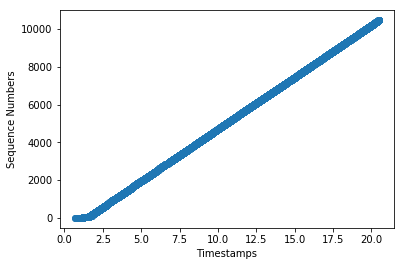

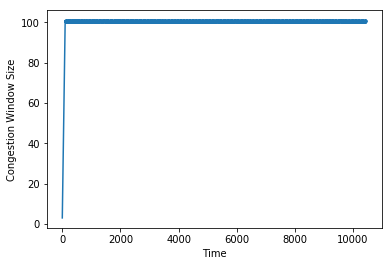

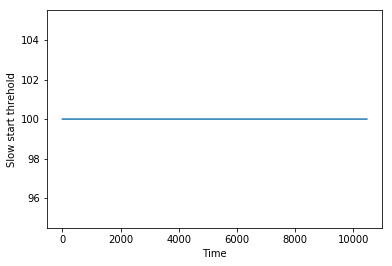

In [24]:
# Run this in the demo

import mpld3
mpld3.enable_notebook()

mahimahi_settings = {
    'delay': 88,
    'queue_size': 60,
    'trace_file': TRACE_FILES['100.42MBPS']
}
port = get_open_udp_port()
port2 = get_open_udp_port()
strat = CubicStrategy(0.4)
plot = run_with_mahi_settings(mahimahi_settings, 20, [Sender(port, strat)])

In [15]:
from src.strategies import SenderStrategy
from src.senders import Sender
import json
import time
from typing import List, Dict, Optional


class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.initial_cwnd = initial_cwnd
        self.slow_start_thresh = slow_start_thresh

        # List of tuples of ack_time and seq_num

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0

        self.duplicated_ack = None
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # Returns true if the congestion window is not full

        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        if self.retransmitting_packet and time.time() - self.time_of_retransmit > 1:
            print("Doing another retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            
            print("Doing a retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'sent_bytes': self.sent_bytes
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:

        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = max(1, self.cwnd/2)
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                # Acknowledge all packets where seq_num < ack['seq_num']
                # Throw out all unacknowledged packets and start over

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.ack_count += 1
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
                print("in slow start, threshold is %d" % self.slow_start_thresh)

            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)


[sender] Connected to receiver: 100.64.0.8:35133

in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
in slow start, threshold is 10
Doing a retransmit of 150
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold is 75
in slow start, threshold 

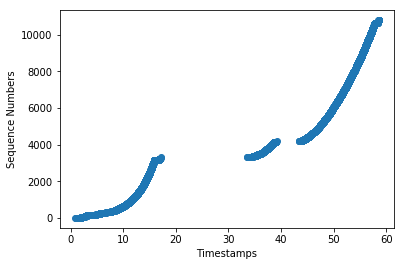

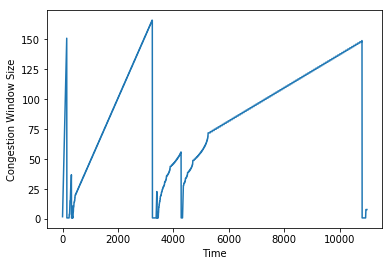

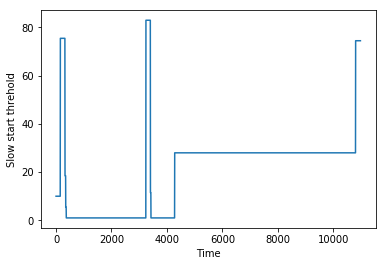

In [18]:
# Plain old tahoe

# Results for sender 48188:
# Total Acks: 902
# Num Duplicate Acks: 122
# % duplicate acks: 13.525499
# Total bytes sent: 47786
# Throughput (bytes/s): 4778.600000
# Average RTT (ms): 262.890045

# Run this in the demo

mahimahi_settings = {
    'delay': 88,
    'queue_size': 40,
    'trace_file': TRACE_FILES['2.64MBPS']
    #'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strat)])

In [41]:
mahimahi_settings = {
    'delay': 130,
    'queue_size': 426,
    'trace_file': TRACE_FILES['3.04MBPS']
}

In [ ]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}


In [ ]:
mahimahi_settings = {
    'delay': 45,
    'queue_size': 450,
    'trace_file': TRACE_FILES['114.68MBPS']
}


In [ ]:
# Absurd Queue Size case

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}
